In [1]:
import os
from dotenv import load_dotenv
from datetime import datetime
import logging

from pathlib import Path
import sys
sys.path.append('..')  # Add parent directory to path

from IPython.display import Image, display, Markdown

from config import Settings, load_project_config, initialize_llm, get_settings
from workflow import create_workflow, run_workflow
from nodes.context_generator_node import context_generator_node
from nodes.terraform_analyzer_node import terraform_analyzer_minor_node, terraform_analyzer_major_node
from nodes.source_code_analyzer_node import source_code_analyzer_minor_node, source_code_analyzer_major_node
from nodes.architecture_diff_node import architecture_diff_node
from nodes.adr_generator_node import adr_generator_node


In [2]:
# Load environment variables from .env file
print(load_dotenv())

# Verify environment variables are loaded
print("Environment variables loaded:")
print(f"OPENAI_API_KEY: {'***' + os.getenv('OPENAI_API_KEY', '')[-4:] if os.getenv('OPENAI_API_KEY') else 'NOT SET'}")
print(f"OPENAI_MODEL: {os.getenv('OPENAI_MODEL', 'gpt-4.1-mini (default)')}")

True
Environment variables loaded:
OPENAI_API_KEY: ***GH0A
OPENAI_MODEL: gpt-4.1-mini (default)


In [ ]:
logging.basicConfig(
    stream=sys.stdout, 
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True # Ensures reconfiguration works in notebooks
)

In [3]:
# Load environment-based settings (from .env)
settings = Settings()
print("Settings loaded from .env:")
print(f"  Model: {settings.openai_model}")
print(f"  Temperature: {settings.temperature}")
print(f"  Max Tokens: {settings.max_tokens}")

Settings loaded from .env:
  Model: gpt-4.1-mini
  Temperature: 0.1
  Max Tokens: None


---

In [4]:
# Load project configuration from YAML
project_dir = "../project-inputs/abelaa"
# project_dir = "../project-inputs/chef"
# project_dir = "../project-inputs/serverlessmike"

project_config = load_project_config(project_dir)

print("\nProject configuration loaded:")
print(f"  Project Name: {project_config['project_name']}")
print(f"  Terraform Minor: {project_config['terraform_minor']}")
print(f"  Terraform Major: {project_config['terraform_major']}")
print(f"  Source Code ZIP: {project_config['source_code_zip']}")
print(f"  Knowledge Base: {project_config['knowledge_base']}")
print(f"  LLM Model: {project_config['llm']['model']}")


Project configuration loaded:
  Project Name: abelaa
  Terraform Minor: abelaa_cloud_evolucion_menor.tf
  Terraform Major: abelaa_cloud_evolucion_mayor.tf
  Source Code ZIP: abelaa_app.zip
  Knowledge Base: knowledge/IAC.txt
  LLM Model: gpt-4.1-mini


In [5]:
# Initialize the global LLM instance
llm = initialize_llm(settings)
print("\nLLM initialized:")
print(f"  Model: {llm.model_name}")
print(f"  Temperature: {llm.temperature}")


LLM initialized:
  Model: gpt-4.1-mini
  Temperature: 0.1


2026-02-15 11:28:21 - INFO - Creating workflow terraform=False

Workflow created successfully!


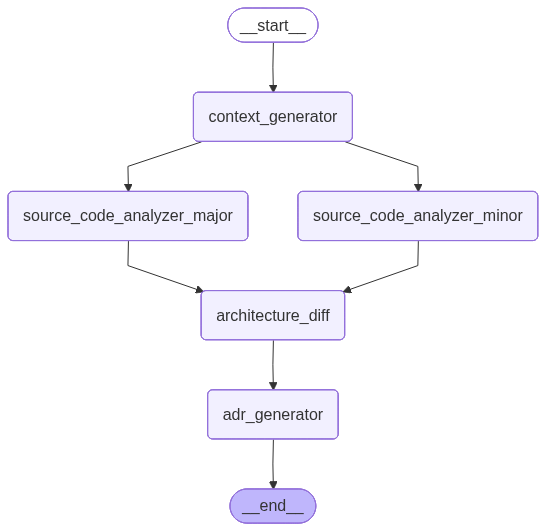

In [12]:
# Create the workflow graph
app = create_workflow(project_dir, include_terraform=False)

print("\nWorkflow created successfully!")
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
# Build initial state from project config
initial_state = {
    "project_name": project_config["project_name"],
    "terraform_minor": str(Path(project_dir) / project_config["terraform_minor"]),
    "terraform_major": str(Path(project_dir) / project_config["terraform_major"]),
    "source_code_zip": str(Path(project_dir) / project_config["source_code_zip"]),
    "knowledge_base": project_config["knowledge_base"],
    "timestamp": datetime.now().isoformat()
}

print("\nInitial state prepared:")
for key, value in initial_state.items():
    if key not in ["terraform_minor", "terraform_major", "source_code_zip"]:
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {Path(value).name}")


Initial state prepared:
  project_name: abelaa
  terraform_minor: abelaa_cloud_evolucion_menor.tf
  terraform_major: abelaa_cloud_evolucion_mayor.tf
  source_code_zip: abelaa_app.zip
  knowledge_base: knowledge/IAC.txt
  timestamp: 2026-02-15T11:28:29.598999


---

In [14]:
result = await run_workflow(project_dir=project_dir, initial_state=initial_state, workflow=app)
result

2026-02-15 11:28:52 - INFO - STEP: context_generator_node
2026-02-15 11:28:52 - INFO - STEP: source_code_analyzer_major_node
2026-02-15 11:28:52 - INFO - STEP: source_code_analyzer_minor_node
2026-02-15 11:29:26 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-15 11:29:29 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-15 11:29:29 - INFO - STEP: architecture_diff_node
2026-02-15 11:29:44 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-15 11:29:44 - INFO - STEP: adr_generator_node
2026-02-15 11:30:25 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'terraform_minor': '../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf',
 'terraform_major': '../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf',
 'source_code_zip': '../project-inputs/abelaa/abelaa_app.zip',
 'knowledge_base': '../knowledge/IAC.txt',
 'architectural_context': '\n# Theoretical Introduction to Software Architecture, Monolithic Architecture, and Microservices Architecture\n\n## 1. Software Architecture\n\n### Definition\nSoftware architecture refers to the fundamental structures of a software system and the discipline of creating such structures and systems. It involves the high-level structuring of software components, their relationships, and the principles and guidelines governing their design and evolution over time.\n\n### Purpose and Importance\n- **Blueprint for Development:** Acts as a blueprint guiding the design and implementation of the system.\n- **Communication Tool:** Facilitates communication among stakeholders including developers, architect

---

In [10]:
# Test context generator node
print("\n--- Testing Context Generator Node ---")

context_result = await context_generator_node(initial_state, llm=llm)

print(f"Architectural context generated: {len(context_result['architectural_context'])} characters")
print(f"Project structure extracted: {len(context_result['project_structure'])} characters")
print()

# display(Markdown(context_result['architectural_context']))
# display(Markdown(context_result['project_structure']))
print(context_result['project_structure'])

context_result


--- Testing Context Generator Node ---
2026-02-15 11:14:26 - INFO - STEP: context_generator_node
Architectural context generated: 7145 characters
Project structure extracted: 860 characters

PROJECT STRUCTURE ANALYSIS

Total Directories: 1
Python Files: 0
TypeScript Files: 0
TSX Files: 0
JavaScript Files: 0
PHP Files: 2
Java Files: 0
XML Files: 0
Terraform Files: 0
Configuration Files: 0
Other Files: 8


PROJECT FILE TREE:
AppKernel.php
config
    ├── config.yml
    ├── config_dev.yml
    ├── config_test.yml
    ├── migrations.yml
    ├── parameters.php
    ├── parameters_test.yml
    ├── pcmt_migrations.yml
    ├── routing.yml
    └── security_test.yml


FILE TYPE BREAKDOWN:

  PHP Source Files:
    - config/parameters.php
    - AppKernel.php

  Other Files:
    - config/config.yml
    - config/config_dev.yml
    - config/config_test.yml
    - config/migrations.yml
    - config/parameters_test.yml
    - config/pcmt_migrations.yml
    - config/routing.yml
    - config/security_test.ym

{'project_name': 'abelaa',
 'terraform_minor': '../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf',
 'terraform_major': '../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf',
 'source_code_zip': '../project-inputs/abelaa/abelaa_app.zip',
 'knowledge_base': '../knowledge/IAC.txt',
 'timestamp': '2026-02-15T11:12:25.805742',
 'architectural_context': '\n# Theoretical Introduction to Software Architecture, Monolithic Architecture, and Microservices Architecture\n\n## 1. Software Architecture\n\n### Definition\nSoftware architecture refers to the fundamental structures of a software system and the discipline of creating such structures and systems. It involves the high-level structuring of software components, their relationships, and the principles and guidelines governing their design and evolution over time.\n\n### Purpose and Importance\n- **Blueprint for Development:** Acts as a blueprint guiding the design and implementation of the system.\n- **Communication Tool:** Facil

In [11]:
# for k, v in context_result['source_code_dict'].items():
#     print("="*10+" "+k)
#     print(v)
#     print("="*20)

In [12]:
# display(Markdown(context_result['architectural_context'].strip()))
# print(context_result['architectural_context'].strip())


---

In [13]:
# path_knowledge_base = context_result['knowledge_base']
# context_result['knowledge_base'] = "../" +  path_knowledge_base if not path_knowledge_base.startswith("../") else path_knowledge_base


In [14]:
print("\n--- Testing Terraform Analyzer Minor Node ---")

terraform_result1 = await terraform_analyzer_minor_node(context_result, llm=llm)

# display(Markdown(context_result['terraform_analysis_minor']))
terraform_result1['terraform_analysis_minor']


--- Testing Terraform Analyzer Minor Node ---
2026-02-15 11:14:26 - INFO - STEP: terraform_analyzer_minor_node
2026-02-15 11:14:28 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'microservices': False,
 'confidence': 0.85,
 'signals_for': ['Use of Terraform modules for infrastructure abstraction [C# module "covid-dev"]',
  'Remote state usage indicating some separation of concerns [C# data terraform_remote_state]'],
 'signals_against': ['Single main module deployment unit without multiple service-specific modules [C# module "covid-dev"]',
  'No evidence of multiple independently deployable services such as ECS services, Lambda functions, or Kubernetes deployments [R#1, C# Terraform code]',
  'No asynchronous communication resources like SQS, SNS, EventBridge, or Kafka [R#4, C# Terraform code]',
  'No evidence of distributed deployment across multiple availability zones or regions beyond basic subnet usage [R#5, C# Terraform code]',
  'No per-service autoscaling or dedicated security groups indicating independent service boundaries [R#3, C# Terraform code]',
  'Single backend state file for the environment indicating a monolithic state management [C# terraform

In [15]:
print("\n--- Testing Terraform Analyzer Major Node ---")

terraform_result2 = await terraform_analyzer_major_node(context_result, llm=llm)

# display(Markdown(context_result['terraform_analysis_major']))
terraform_result2['terraform_analysis_major']


--- Testing Terraform Analyzer Major Node ---
2026-02-15 11:14:28 - INFO - STEP: terraform_analyzer_major_node
2026-02-15 11:14:32 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'microservices': False,
 'confidence': 0.9,
 'signals_for': ['Use of multiple Terraform modules for network and compute infrastructure [R2], [C modules/pcmt-network/cloudpcmt-network.tf]',
  'Use of multiple AWS providers and remote state data sources indicating some separation of concerns [C covid-dev/main.tf]'],
 'signals_against': ['No evidence of multiple independently deployable services such as aws_ecs_service, aws_lambda_function, or kubernetes_deployment [R1]',
  'Single AWS EC2 instance deployment per environment with docker deployment via Ansible, indicating a monolithic deployment unit [C modules/pcmt/compute.tf]',
  'No asynchronous communication resources like SQS, SNS, EventBridge, or Kafka detected [R4]',
  'Shared security groups and subnet usage without per-service isolation [C modules/pcmt-network/cloudpcmt-network.tf]',
  'No evidence of independent scaling or autoscaling per service [R3]',
  'No distributed deployment patterns such as multi-AZ replicas or load bala

---

In [16]:
print("\n--- Testing Source Code Analyzer Minor Node ---")

source_code_result1 = await source_code_analyzer_minor_node(context_result, llm=llm)

source_code_result1['improved_analysis_minor']


--- Testing Source Code Analyzer Minor Node ---
2026-02-15 11:14:32 - INFO - STEP: source_code_analyzer_minor_node
2026-02-15 11:15:07 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'# Architecture Analysis of the Hybrid Solution\n\n---\n\n## 1. Project Structure and Codebase Organization\n\n### Monolithic vs Modular Organization\n\n- The project consists primarily of a **single PHP codebase** with no Python or Terraform source files present in the analyzed project structure (despite the initial mention of Python and Terraform files, none were found in the project directory).\n- The core application is structured around the Symfony PHP framework, as evidenced by the `AppKernel.php` file, which is the standard bootstrap class for Symfony applications.\n- The project organizes functionality into **bundles**, a Symfony modularization concept. Bundles encapsulate features and can be considered modules or components within the monolith.\n- The bundles registered in `AppKernel.php` include:\n  - Custom bundles (e.g., `ManufacturerBundle`, `Pcmt*Bundles`, `AcmeAppBundle`)\n  - PIM (Product Information Management) related bundles (e.g., `AkeneoPimEnrichmentBundle`, `Akene

In [17]:
# display(Markdown(context_result['improved_analysis_minor']))
# print(context_result['improved_analysis_minor']) #.strip('"')

In [18]:
print("\n--- Testing Source Code Analyzer Major Node ---")

source_code_result2 = await source_code_analyzer_major_node(context_result, llm=llm)

source_code_result2['improved_analysis_major']


--- Testing Source Code Analyzer Major Node ---
2026-02-15 11:15:07 - INFO - STEP: source_code_analyzer_major_node
2026-02-15 11:15:31 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'# Architecture Analysis of the Given Solution\n\n---\n\n## 1. Project Structure and Codebase Organization\n\n### Overview\n\n- The project consists primarily of PHP source files and configuration files.\n- The root contains `AppKernel.php`, a central Symfony Kernel class responsible for bootstrapping the application.\n- The `config` directory holds multiple YAML and PHP configuration files, including environment-specific configurations (`config_dev.yml`, `config_test.yml`), routing, security, and migration settings.\n- No Python or Terraform files are present in the provided source code snapshot, despite the initial mention.\n- The PHP codebase is organized as a **single Symfony application** with multiple bundles registered within the kernel.\n\n### Monolithic vs Modular\n\n- The architecture is **modular within a monolithic deployment**:\n  - The Symfony framework encourages modularity via bundles, which are self-contained units of code encapsulating features.\n  - The `AppKernel.ph

In [19]:
# display(Markdown(context_result['improved_analysis_major']))
# print(context_result['improved_analysis_major']) #.strip('"')

---

In [20]:
print("\n--- Testing Diff Analysis Node ---")

diff_result = await architecture_diff_node(context_result, llm=llm)

diff_result['architecture_diff']


--- Testing Diff Analysis Node ---
2026-02-15 11:15:31 - INFO - STEP: architecture_diff_node
2026-02-15 11:15:44 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'# Key Architecture Decisions in Migrating from Hybrid to Microservices Version\n\n---\n\n## 1. Decomposition Strategy: From Modular Monolith to Independently Deployable Services\n\n**Description:**  \nDeciding how to break down the existing modular monolith (organized as Symfony bundles) into multiple independent microservices, each encapsulating a specific business capability.\n\n**Key Differences Necessitating This Decision:**  \n- Hybrid version is a single deployable unit with multiple bundles running in one Symfony kernel process.  \n- Microservices version requires multiple Lambda functions, each independently deployable and responsible for distinct functionality.  \n- The need to isolate services for independent development, deployment, and scaling.\n\n**Architectural Impact:**  \n- Introduction of clear service boundaries replacing tightly coupled bundles.  \n- Each microservice owns its codebase, runtime, and lifecycle, enabling independent evolution.  \n- Increased complexit

In [21]:
# display(Markdown(context_result['architecture_diff']))
# print(context_result['architecture_diff']) #.strip('"')

---

In [22]:
print("\n--- Testing ADR Generation Node ---")

adr_result = await adr_generator_node(context_result, llm=llm)

adr_result['adr_files']


--- Testing ADR Generation Node ---
2026-02-15 11:15:44 - INFO - STEP: adr_generator_node
2026-02-15 11:16:20 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'abelaa_ADR_1.md': '# ADR: Decomposition Strategy\n\n## Title\nDecomposition Strategy: From Modular Monolith to Independently Deployable Services\n\n## Status\nAccepted\n\n## Motivation\nThe existing hybrid architecture is a modular monolith where multiple Symfony bundles run within a single kernel process, tightly coupled and deployed as one unit. To achieve independent development, deployment, and scaling, it is necessary to break down the monolith into multiple microservices, each encapsulating a specific business capability. This decomposition enables clearer service boundaries, autonomy, and scalability, addressing the limitations of the monolithic approach and aligning with microservices principles.\n\n## Decision Drivers\n- Need for independent development and deployment of services\n- Requirement for scalability per business capability\n- Desire to improve modularity and maintainability\n- Constraints of existing tightly coupled bundles within a single process\n- Necessity to 

In [15]:
context_result = result

folder_path = Path("../output-adrs/"+project_config['project_name'])
# folder_path.mkdir(parents=True, exist_ok=True) 

for k,adr in context_result['adr_files'].items():
    print("="*10+" "+k)
    display(Markdown(adr))
    print(("="*30))
    print()
    # with (folder_path / k).open("w") as file:
    #     file.write(adr)

    print(f"File '{k}' written to '{folder_path}'")

========== abelaa_ADR_1.md


# ADR: Architectural Decomposition and Service Boundaries

## Title
Defining Clear Service Boundaries for Microservices Decomposition

## Status
Accepted

## Motivation
The existing application was structured as a modular monolith using Symfony bundles within a single deployment unit, which limited independent development, deployment, and scaling of components. To achieve greater agility, scalability, and maintainability, it became necessary to decompose the monolith into independently deployable microservices aligned with distinct business capabilities and domain contexts. This decomposition enables clearer separation of concerns and supports independent lifecycle management of services.

## Decision Drivers
- Need for independent development and deployment of components
- Requirement for scalability at service level
- Desire to align services with business capabilities and domain boundaries
- Limitations of single deployment unit in modular monolith
- Necessity to redesign domain models and data ownership per service

## Main Decision
The architecture was decomposed by identifying clear service boundaries aligned with business capabilities and domain contexts, extracting microservices from the existing Symfony bundles. Each microservice was designed as an independently deployable unit encapsulating specific functionality, replacing in-process method calls with API-based communication. This approach enforces separation of concerns at the service level and enables independent scaling, deployment, and evolution of each service.

## Alternatives
- Maintain Modular Monolith: Continue using Symfony bundles within a single deployment unit without decomposition
- Layered Modular Monolith: Introduce stricter modular boundaries within the monolith without full decomposition
- Modular Monolith with Shared Libraries: Extract common functionality into shared libraries but keep single deployment

## Pros
Main decision:
- Enables independent deployment and scaling of services
- Improves maintainability by isolating business capabilities
- Facilitates technology diversity and team autonomy
- Supports independent lifecycle management

Maintain Modular Monolith:
- Simpler initial development and deployment
- Lower operational complexity
- Easier to test end-to-end in a single process

Layered Modular Monolith:
- Improves modularity without full complexity of microservices
- Easier transition path than full decomposition

Modular Monolith with Shared Libraries:
- Promotes code reuse
- Maintains single deployment simplicity

## Cons
Main decision:
- Increased architectural and operational complexity
- Requires redesign of domain models and data ownership
- Necessitates new communication mechanisms and fault tolerance

Maintain Modular Monolith:
- Limits scalability and independent deployment
- Tighter coupling between components
- Slower development cycles as codebase grows

Layered Modular Monolith:
- Still shares deployment and scaling limitations
- May not fully isolate faults

Modular Monolith with Shared Libraries:
- Shared libraries can create tight coupling
- Does not address deployment and scaling challenges

## Consequences
The chosen decomposition enables independent scaling, deployment, and evolution of services, improving maintainability and aligning architecture with business domains. However, it introduces complexity in inter-service communication, requires redesign of domain models, and demands new operational capabilities such as service orchestration and monitoring. In the long term, this decision supports agility and scalability but requires investment in infrastructure and team skills.

## Validation
Validation was performed through incremental extraction of services from the monolith, verifying independent deployment and functionality of each microservice. Architectural reviews and domain-driven design workshops supported boundary identification. Monitoring and testing of inter-service communication ensured correctness and performance.

## Additional Information



File 'abelaa_ADR_1.md' written to '../output-adrs/abelaa'
========== abelaa_ADR_2.md


# ADR: Communication Style and Infrastructure Shift

## Title
Transition from In-Process Calls to Network-Based API Communication

## Status
Accepted

## Motivation
The modular monolith used in-process method calls for communication between bundles, which is efficient but tightly couples components within a single runtime. Migrating to microservices requires services to communicate over network boundaries, necessitating a shift to API-based communication managed by an API Gateway. This change is essential to enable independent deployment, scaling, and fault isolation of services.

## Decision Drivers
- Requirement for independent service deployment and scaling
- Need to decouple components across process and network boundaries
- Introduction of serverless Lambda functions requiring network communication
- Necessity to handle network latency, fault tolerance, and retries
- Requirement for API design, versioning, and contract management

## Main Decision
The communication style was shifted from in-process method calls to network-based communication using HTTP APIs managed by an API Gateway. Each microservice exposes well-defined APIs, and services interact asynchronously or synchronously over the network. This approach supports independent scaling and deployment but requires implementing resilience patterns, monitoring, and robust API management.

## Alternatives
- Retain In-Process Communication: Keep communication within a single process by avoiding full decomposition
- Message Bus Communication: Use asynchronous messaging middleware for inter-service communication
- Shared Database Communication: Services communicate indirectly via shared database access

## Pros
Main decision:
- Enables independent deployment and scaling
- Supports clear API contracts and versioning
- Facilitates fault isolation and resilience patterns
- Aligns with serverless infrastructure

Retain In-Process Communication:
- Simplifies communication with low latency
- Easier to implement and test

Message Bus Communication:
- Decouples services asynchronously
- Improves scalability and fault tolerance

Shared Database Communication:
- Simplifies data sharing
- Avoids network calls for some interactions

## Cons
Main decision:
- Introduces network latency and potential partial failures
- Increases complexity in handling retries and fault tolerance
- Requires API management and monitoring infrastructure

Retain In-Process Communication:
- Limits scalability and independent deployment
- Tightly couples services

Message Bus Communication:
- Adds complexity in message handling and eventual consistency
- Requires additional infrastructure

Shared Database Communication:
- Creates tight coupling via shared data
- Complicates data consistency and ownership

## Consequences
This decision introduces network complexity, requiring robust error handling, monitoring, and API governance. It improves scalability and fault isolation but demands new operational capabilities and development practices. The system must handle partial failures and latency, impacting performance and reliability considerations.

## Validation
Validation included prototyping API Gateway integration with Lambda functions, testing synchronous and asynchronous communication patterns, and implementing monitoring and retry mechanisms. Performance benchmarks and fault injection tests were conducted to assess resilience.

## Additional Information



File 'abelaa_ADR_2.md' written to '../output-adrs/abelaa'
========== abelaa_ADR_3.md


# ADR: Deployment Model and Infrastructure Automation

## Title
Adopting Serverless Deployment with Infrastructure as Code Automation

## Status
Accepted

## Motivation
The existing monolithic application was deployed as a single artifact without explicit infrastructure automation. Migrating to microservices implemented as AWS Lambda functions requires a new deployment model that supports independent deployment, scaling, and operational automation. Infrastructure as code (IaC) is necessary to provision and manage the API Gateway, Lambda functions, and related resources consistently and repeatably.

## Decision Drivers
- Need for independent deployment of multiple microservices
- Requirement for automated, repeatable infrastructure provisioning
- Desire to leverage serverless benefits such as fine-grained scaling and cost optimization
- Necessity to support DevOps practices and CI/CD pipelines
- Operational complexity of managing multiple services and resources

## Main Decision
The deployment model was changed to use multiple serverless Lambda functions orchestrated behind an API Gateway, with infrastructure managed via infrastructure as code tools. This enables automated, repeatable deployments supporting independent service lifecycles, fine-grained scaling, and cost optimization. CI/CD pipelines were adapted to handle multiple services and their infrastructure dependencies.

## Alternatives
- Single Monolithic Deployment: Continue deploying a single artifact without automation
- Containerized Microservices: Deploy microservices as containers managed by orchestration platforms
- Manual Infrastructure Management: Provision resources manually without IaC

## Pros
Main decision:
- Enables independent deployment and scaling of services
- Supports automated, repeatable infrastructure provisioning
- Optimizes costs via serverless scaling
- Facilitates DevOps and continuous delivery practices

Single Monolithic Deployment:
- Simpler deployment process
- Lower initial operational overhead

Containerized Microservices:
- Provides control over runtime environment
- Supports complex service dependencies

Manual Infrastructure Management:
- Immediate setup without learning IaC tools
- Flexibility in resource provisioning

## Cons
Main decision:
- Requires investment in IaC tooling and pipeline development
- Increases operational complexity
- Demands new skills for serverless and cloud-native paradigms

Single Monolithic Deployment:
- Limits scalability and agility
- Difficult to manage multiple service lifecycles

Containerized Microservices:
- Adds complexity of container orchestration
- Higher operational overhead than serverless

Manual Infrastructure Management:
- Prone to errors and inconsistencies
- Difficult to scale and maintain over time

## Consequences
This decision improves scalability, cost efficiency, and deployment agility but requires organizational changes towards DevOps culture and cloud-native practices. It increases operational complexity and necessitates investment in automation tooling and skills development. Over time, it supports faster delivery and more reliable operations.

## Validation
Validation involved setting up CI/CD pipelines for Lambda functions and API Gateway provisioning using IaC tools, performing automated deployments, and monitoring deployment success and rollback capabilities. Cost and scaling behavior were monitored in production.

## Additional Information



File 'abelaa_ADR_3.md' written to '../output-adrs/abelaa'
========== abelaa_ADR_4.md


# ADR: Data Management and Decentralization

## Title
Decentralizing Data Ownership to Service-Specific Stores

## Status
Accepted

## Motivation
The hybrid monolith used a shared relational database accessed by all bundles, creating tight coupling and bottlenecks. Migrating to microservices requires decentralizing data management so each service owns and manages its own data store or accesses data through well-defined APIs. This reduces coupling, improves fault isolation, and enables independent evolution of services, but introduces challenges in data consistency and transaction management.

## Decision Drivers
- Need to reduce coupling between services
- Requirement for independent service evolution and scaling
- Avoidance of shared database bottlenecks and single points of failure
- Challenges of distributed transactions and consistency
- Necessity to adopt eventual consistency and event-driven patterns

## Main Decision
Data management was decentralized by assigning each microservice ownership of its own data store or data access patterns, avoiding shared database schemas. Services communicate data changes via APIs or events, adopting eventual consistency models where necessary. This approach improves fault isolation and scalability but requires redesigning data access layers and implementing mechanisms for data synchronization and consistency.

## Alternatives
- Shared Relational Database: Continue using a single shared database accessed by all services
- Database per Service with Synchronous API Calls: Services access other services' data via synchronous APIs without event-driven patterns
- Centralized Data Access Layer: Introduce a shared data access service mediating database interactions

## Pros
Main decision:
- Improves fault isolation and scalability
- Enables independent service evolution
- Reduces coupling at the data layer
- Supports polyglot persistence

Shared Relational Database:
- Simplifies data consistency and transactions
- Easier to implement initially

Database per Service with Synchronous API Calls:
- Maintains data ownership per service
- Simplifies data access without event-driven complexity

Centralized Data Access Layer:
- Provides controlled access to shared data
- Simplifies data governance

## Cons
Main decision:
- Increases complexity in maintaining data consistency
- Requires new patterns for eventual consistency and distributed transactions
- Demands redesign of data access and synchronization

Shared Relational Database:
- Creates tight coupling and bottlenecks
- Limits independent scaling and evolution

Database per Service with Synchronous API Calls:
- Introduces latency and potential cascading failures
- Limits scalability of data access

Centralized Data Access Layer:
- Becomes a potential bottleneck and single point of failure
- Reduces service autonomy

## Consequences
Decentralizing data ownership improves scalability and fault tolerance but complicates data consistency and transaction management. It necessitates adopting eventual consistency, event-driven architectures, and careful design of data synchronization mechanisms. This decision impacts development complexity and operational monitoring but aligns with microservices principles for autonomy and resilience.

## Validation
Validation included prototyping service-specific data stores, implementing event-driven data synchronization, and testing consistency models under load. Data access patterns were reviewed for correctness and performance.

## Additional Information



File 'abelaa_ADR_4.md' written to '../output-adrs/abelaa'
========== abelaa_ADR_5.md


# ADR: Migration Strategy and Incremental Evolution

## Title
Incremental Migration from Hybrid Monolith to Microservices

## Status
Accepted

## Motivation
Migrating from a modular monolith to a microservices architecture is complex and risky if done in a big-bang approach. An incremental migration strategy allows gradual extraction of functionality into microservices, minimizing disruption and enabling coexistence of legacy and new components. This approach supports iterative validation and reduces operational risk during the transition.

## Decision Drivers
- Need to minimize disruption and risk during migration
- Requirement to maintain operational continuity
- Desire to validate architectural changes iteratively
- Support coexistence of monolithic and microservices components
- Manage backward compatibility and interface stability

## Main Decision
The migration was conducted incrementally by gradually extracting functionality from the monolith into multiple Lambda-based microservices coordinated via API Gateway. The hybrid state with a single Lambda function coexisting with monolithic components was used as an intermediate step. This approach allowed careful management of interfaces, backward compatibility, and operational readiness, reducing migration risk.

## Alternatives
- Big-Bang Migration: Replace the monolith entirely with microservices in a single deployment
- Parallel Systems: Develop microservices in parallel and switch over completely after completion
- Strangler Pattern: Incrementally replace parts of the monolith by routing requests to new services

## Pros
Main decision:
- Minimizes operational risk and disruption
- Supports coexistence and gradual transition
- Enables iterative validation and feedback
- Allows phased investment and learning

Big-Bang Migration:
- Potentially faster transition
- Simplifies architecture post-migration

Parallel Systems:
- Allows independent development without affecting legacy
- Enables full testing before cutover

Strangler Pattern:
- Provides controlled incremental replacement
- Reduces risk by isolating changes

## Cons
Main decision:
- Requires careful interface and compatibility management
- Prolongs coexistence complexity
- Demands operational overhead for hybrid state

Big-Bang Migration:
- High risk of failure and disruption
- Difficult to rollback

Parallel Systems:
- Increased resource requirements
- Complex data synchronization

Strangler Pattern:
- May require complex routing and proxying
- Incremental complexity in deployment

## Consequences
The incremental migration strategy reduces risk and supports continuous delivery but requires managing hybrid states and interface stability. It prolongs the transition period and demands operational discipline. Over time, it enables smoother adoption of microservices and organizational learning.

## Validation
Validation was achieved through staged deployments, monitoring coexistence of monolith and microservices, and iterative testing of extracted services. Rollback plans and interface contracts were enforced to ensure stability.

## Additional Information



File 'abelaa_ADR_5.md' written to '../output-adrs/abelaa'


---